# Imports

In [1]:
import os
os.chdir(f"/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")
import sys
import time
from glob import glob
import json
import numpy as np
import xarray as xr
import scipy as sp
from scipy import special
from scipy.signal import hilbert
from numpy.fft import fft, ifft, fftfreq

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':22})
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.gridspec as gs

from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# # Cartopy
# from cartopy import crs as ccrs
# from cartopy import feature as cf
# from cartopy import util as cutil
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

# Auxiliary Functions
import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo
from ipynb.fs.full.bmh_colors import bmh_colors
from ipynb.fs.full.rounding_functions import round_out, round_to_multiple
from ipynb.fs.full.modified_colormap import Ahmed21_colormap

Ahmed_cmap = Ahmed21_colormap()
from ipynb.fs.full.tapering_functions import taper_meridionally, fringe_region_damping_function
from ipynb.fs.full.perlin_noise import generate_perlin_noise_2d
from ipynb.fs.full.normalize_data import normalize_data

sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/')
from ipynb.fs.full.numerical_solver_plotting_functions import plot_horizontal_structure, animate_horizontal_structure

# import obspy

# Load experiment parameters

In [2]:
output_file_directory = (
    f"output/Ahmed-21/"
    + f"epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_epsq=epsq(y)_epst=epst(y)_diffusive-damped-moist-coupled-simulation"
)

with open(
    f"{output_file_directory}/experiment_variables.json", 'r') as json_file:
    loaded_experiment_variables = json.load(json_file)

simulation_moisture = loaded_experiment_variables['simulation_moisture']
moisture_advection = loaded_experiment_variables['moisture_advection']
simulation_damping = loaded_experiment_variables['simulation_damping']
moisture_coupling = loaded_experiment_variables['moisture_coupling']
simulation_diffusion = loaded_experiment_variables['simulation_diffusion']
fringe_region = loaded_experiment_variables['fringe_region']
GRAVITY = loaded_experiment_variables['GRAVITY']
EQUIVALENT_DEPTH = loaded_experiment_variables['EQUIVALENT_DEPTH']
CORIOLIS_PARAMETER = loaded_experiment_variables['CORIOLIS_PARAMETER']
EARTH_RADIUS = loaded_experiment_variables['EARTH_RADIUS']
AIR_DENSITY = loaded_experiment_variables['AIR_DENSITY']
WATER_DENSITY = loaded_experiment_variables['WATER_DENSITY']
LATENT_HEAT = loaded_experiment_variables['LATENT_HEAT']
SPECIFIC_HEAT = loaded_experiment_variables['SPECIFIC_HEAT']
DIFFUSIVITY = loaded_experiment_variables['DIFFUSIVITY']
laplacian_u = loaded_experiment_variables['laplacian_u']
laplacian_v = loaded_experiment_variables['laplacian_v']
laplacian_T = loaded_experiment_variables['laplacian_T']
laplacian_q = loaded_experiment_variables['laplacian_q']
METERS_PER_DEGREE = loaded_experiment_variables['METERS_PER_DEGREE']
SECONDS_PER_DAY = loaded_experiment_variables['SECONDS_PER_DAY']
COLUMN_AVERAGE_MASS = loaded_experiment_variables['COLUMN_AVERAGE_MASS']
GROSS_DRY_STABILITY = loaded_experiment_variables['GROSS_DRY_STABILITY']
MOISTURE_SENSITIVITY = loaded_experiment_variables['MOISTURE_SENSITIVITY']
TEMPERATURE_SENSITIVITY = loaded_experiment_variables['TEMPERATURE_SENSITIVITY']
CLOUD_RADIATIVE_PARAMETER = loaded_experiment_variables['CLOUD_RADIATIVE_PARAMETER']
sigma_x_multiplier = loaded_experiment_variables['sigma_x_multiplier']
sigma_y_multiplier = loaded_experiment_variables['sigma_y_multiplier']
ZONAL_MOISTENING_PARAMETER = loaded_experiment_variables['ZONAL_MOISTENING_PARAMETER']
MERIDIONAL_MOISTENING_PARAMETER = loaded_experiment_variables['MERIDIONAL_MOISTENING_PARAMETER']
MERIDIONAL_OFFSET_PARAMETER = loaded_experiment_variables['MERIDIONAL_OFFSET_PARAMETER']
gravity_wave_phase_speed = loaded_experiment_variables['gravity_wave_phase_speed']
time_scale = loaded_experiment_variables['time_scale']
length_scale = loaded_experiment_variables['length_scale']
gross_moisture_stratification = loaded_experiment_variables['gross_moisture_stratification']
effective_sensitivity = loaded_experiment_variables['effective_sensitivity']
effective_gross_moist_stability = loaded_experiment_variables['effective_gross_moist_stability']
scaled_zonal_parameter = loaded_experiment_variables['scaled_zonal_parameter']
scaled_meridional_parameter = loaded_experiment_variables['scaled_meridional_parameter']
n_days = loaded_experiment_variables['n_days']
n_chunks = loaded_experiment_variables['n_chunks']
n_time_steps = loaded_experiment_variables['n_time_steps']
meridional_domain_length = loaded_experiment_variables['meridional_domain_length']
zonal_domain_length = loaded_experiment_variables['zonal_domain_length']
nt = loaded_experiment_variables['nt']    
nx = loaded_experiment_variables['nx']
ny = loaded_experiment_variables['ny']
zonal_grid_spacing = loaded_experiment_variables['zonal_grid_spacing']
meridional_grid_spacing = loaded_experiment_variables['meridional_grid_spacing']
simulation_length = loaded_experiment_variables['simulation_length']
time_step = loaded_experiment_variables['time_step']
zonal_step_size = loaded_experiment_variables['zonal_step_size']
meridional_step_size = loaded_experiment_variables['meridional_step_size']
CFL_x = loaded_experiment_variables['CFL_x']
CFL_y = loaded_experiment_variables['CFL_y']
fringe_region_latitude = loaded_experiment_variables['fringe_region_latitude']
fringe_region_width = loaded_experiment_variables['fringe_region_width']
fringe_region_strength = loaded_experiment_variables['fringe_region_strength']
grid_scaling = loaded_experiment_variables['grid_scaling']
additional_notes = loaded_experiment_variables['additional_notes']
simulation_name = loaded_experiment_variables['simulation_name']
output_file_directory = loaded_experiment_variables['output_file_directory']
initial_wave = loaded_experiment_variables['initial_wave']
n_wavelengths = loaded_experiment_variables['n_wavelengths']
mode_number = loaded_experiment_variables['mode_number']
initial_condition_name = loaded_experiment_variables['initial_condition_name']
n_rk_steps = loaded_experiment_variables['n_rk_steps']
save_downsampled = loaded_experiment_variables['save_downsampled']

zonal_wavenumber      = 2*np.pi*fftfreq(nx, zonal_step_size)       # zonal wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny, meridional_step_size)  # meridional wavenumbers
frequencies           = 2*np.pi*fftfreq(nt, time_step)             # frequencies

## Compile downsampled data

In [8]:
# Use the most recently run experiment
specified_output_file_directory = output_file_directory
# specified_initial_condition_name = initial_condition_name

# Choose a previous experiment
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=1.00_S=0.003_damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_limited-advection_damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=0.00_implicit_BC_damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.00_epsq=0.00_r=0.0_nx=0.0_ny=0.00_finite-difference-test_free-dry-uncoupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_epsq=epsq(y)_diffusive-damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_epsq=epsq(y)_epst=epst(y)_diffusive-damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_diffusive-damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_limited-advection_damped-moist-coupled-simulation"
specified_initial_condition_name = 'k=3.0_m=1_Kelvin-wave'

downsampled_subfiles = []
n_chunks_load = 8
for c in range(1,n_chunks_load+1):
    # downsampled_subfiles.append(f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{c}of{n_chunks}.nc")
    downsampled_subfiles.append(
        f"{specified_output_file_directory}/{specified_initial_condition_name}_downsampled-model-data_chunk-{c}of{n_chunks_load}.nc"
    )

# downsampled_subfiles = sorted(
#     glob(
#         f"{specified_output_file_directory}/{specified_initial_condition_name}_downsampled-model-data_chunk*of{n_chunks}.nc"
#     )
# )
    
downsampled_data_list = []
for downsampled_file in downsampled_subfiles:
    print(downsampled_file)
    downsampled_data_chunked = xr.load_dataset(downsampled_file)
    downsampled_data_list.append(downsampled_data_chunked)

downsampled_data = xr.concat(downsampled_data_list, dim='time')

output_zonal_velocity = downsampled_data['u'].to_numpy()
output_meridional_velocity = downsampled_data['v'].to_numpy()
output_column_temperature = downsampled_data['T'].to_numpy()
output_column_moisture = downsampled_data['q'].to_numpy()

output_zonal_gridpoints = downsampled_data.x.to_numpy()
output_meridional_gridpoints = downsampled_data.y.to_numpy()
downsampled_timepoints = downsampled_data.time.to_numpy()

output_wavenumber = eval(specified_initial_condition_name.split('_')[0].split('=')[-1])/EARTH_RADIUS

print("downsampled data compiled")

output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_epsq=epsq(y)_epst=epst(y)_diffusive-damped-moist-coupled-simulation/k=3.0_m=1_Kelvin-wave_downsampled-model-data_chunk-1of8.nc
output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_epsq=epsq(y)_epst=epst(y)_diffusive-damped-moist-coupled-simulation/k=3.0_m=1_Kelvin-wave_downsampled-model-data_chunk-2of8.nc
output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_epsq=epsq(y)_epst=epst(y)_diffusive-damped-moist-coupled-simulation/k=3.0_m=1_Kelvin-wave_downsampled-model-data_chunk-3of8.nc
output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_epsq=epsq(y)_epst=epst(y)_diffusive-damped-moist-coupled-simulation/k=3.0_m=1_Kelvin-wave_downsampled-model-data_chunk-4of8.nc
output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_epsq=epsq(y)_epst=epst(y)_diffusive-damped-moist-coupled-simulation/k=3.0_m=1_Kelvin-wave_do

# Visualize Simulation Output

## Horizontal Structure

In [ ]:
# plot_horizontal_structure(
#     np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 30)[0][0],
#     # -1,
#     output_zonal_gridpoints,
#     output_meridional_gridpoints,
#     downsampled_timepoints,
#     output_zonal_velocity, 
#     output_meridional_velocity, 
#     output_column_temperature, 
#     output_column_moisture, 
#     # xlims=(-180,180),
#     # xlims=(-70, 70),
#     # ylims = (
#     #     -np.max(np.abs(output_meridional_gridpoints/METERS_PER_DEGREE)), 
#     #     np.max(np.abs(output_meridional_gridpoints/METERS_PER_DEGREE))
#     # ),
#     # xlims=(0,160),
#     ylims=(-30,30),
#     # zonal_quiver_plot_spacing = 2,
#     # meridional_quiver_plot_spacing = 4, 
#     zonal_quiver_plot_spacing = 5,
#     meridional_quiver_plot_spacing = 4, 
#     save_plot=False, 
#     plotting_units='converted',
#     moisture_anomaly_scaling = 0.6,
#     specified_output_file_directory=specified_output_file_directory,
#     specified_initial_condition_name=specified_initial_condition_name,
# )

physical_parameters = (
    SPECIFIC_HEAT, 
    LATENT_HEAT,
    WATER_DENSITY,
    COLUMN_AVERAGE_MASS,
    EARTH_RADIUS,
    METERS_PER_DEGREE,
    SECONDS_PER_DAY,
)

plotting_parameters = (
    (-180, 180), (-30, 30),
    5,4,
    True, 
    'converted',
    0.6,
    grid_scaling
)

# Plot the initial conditon below
plot_horizontal_structure(
    np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 30)[0][0],
    output_zonal_gridpoints,
    output_meridional_gridpoints,
    downsampled_timepoints,
    zonal_velocity = output_zonal_velocity, 
    meridional_velocity = output_meridional_velocity, 
    column_temperature = output_column_temperature, 
    column_moisture = output_column_moisture, 
    specified_output_file_directory = specified_output_file_directory,
    specified_initial_condition_name = specified_initial_condition_name,
    physical_parameters = physical_parameters,
    simulation_parameters = (simulation_moisture, fringe_region),
    plotting_parameters = plotting_parameters
)

## 3-D structure

In [ ]:
# vertical_gridpoints = np.linspace(0, 17e3, 64)
# scale_height = 10e3
# moisture_structure = np.exp(-vertical_gridpoints/scale_height)
# vertical_wind_structure = -np.cos(2*np.pi*vertical_gridpoints/np.max(vertical_gridpoints))
# horizontal_wind_structure = np.sin(2*np.pi*vertical_gridpoints/np.max(vertical_gridpoints))

# equator_index = np.abs(meridional_gridpoints - 0*METERS_PER_DEGREE).argmin()
# # t = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 45).argmin()
# t=0
# # plt.figure()
# # plt.plot(
# #     vertical_wind_structure,
# #     vertical_gridpoints
# # )

# # plt.plot(
# #     horizontal_wind_structure,
# #     vertical_gridpoints
# # )

# full_moisture = np.einsum(
#     'i, jk-> kji',
#     moisture_structure,
#     output_column_moisture[t]
# )

# full_zonal_wind = np.einsum(
#     'i, jk-> kji',
#     horizontal_wind_structure,
#     output_zonal_velocity[t]
# )

# fig = plt.figure(figsize=(16.5, 11))
# ax = fig.add_subplot(111, projection='3d')

# [X, Y, Z] = np.meshgrid(meridional_gridpoints/1e3, output_zonal_gridpoints/1e3, vertical_gridpoints/1e3)
# data = full_zonal_wind
# kw = {
#     'vmin': data.min(),
#     'vmax': data.max(),
#     'levels': np.linspace(data.min(), data.max(), 21),
#     'cmap' : Ahmed_cmap
# }

# # Plot contour surfaces
# _ = ax.contourf(
#     X[:, :, 0], Y[:, :, 0], data[:, :, 0],
#     zdir='z', offset=0, **kw
# )
# _ = ax.contourf(
#     X[0, :, :], data[0, :, :], Z[0, :, :],
#     zdir='y', offset=Y.max(), **kw
# )
# C = ax.contourf(
#     data[:, equator_index, :], Y[:, equator_index, :], Z[:, equator_index, :],
#     zdir='x', offset=0, **kw
# )

# # # Set limits of the plot from coord limits
# # xmin, xmax = X.min(), X.max()
# # ymin, ymax = Y.min(), Y.max()
# # zmin, zmax = Z.min(), Z.max()
# # ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# # # Plot edges
# # edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
# # ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
# # ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
# # ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# # # Set labels and zticks
# # ax.set(
# #     xlabel='X [km]',
# #     ylabel='Y [km]',
# #     zlabel='Z [m]',
# #     zticks=[0, -150, -300, -450],
# # )

# # Set zoom and angle view
# # ax.view_init(40, -30, 0)
# ax.set_box_aspect((1, 1, 1), zoom=0.9)
# ax.set_zlim(0, 20)

# # Colorbar
# # fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='<q> [J kg m^-2]')

# # Show Figure
# plt.show()

## Meridional Structure

In [ ]:
starting_frame = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 70)[0][0]
ending_frame = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 99)[0][0]
frame_interval = 1
lon_index = np.argmax(output_column_moisture[0, ny//2, :]) 

plt.style.use('bmh')
[fig, ax] = plt.subplots(1, 1, figsize=(16,6))
ax.set_title(f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days")

axh_line = ax.axhline(y=0, color='k', lw=2, ls=':')

u_line = ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    output_zonal_velocity[starting_frame, :, lon_index],
    color=bmh_colors('purple'),
    label='u'
)

v_line = ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    output_meridional_velocity[starting_frame, :, lon_index],
    color=bmh_colors('green'),
    label='v'
)

T_line = ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    output_column_temperature[starting_frame, :, lon_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    label=r"$\frac{c}{M_s}\langle T \rangle$",
)

q_line = ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    output_column_moisture[starting_frame, :, lon_index]*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    label=r"$\frac{c}{M_q}\langle q \rangle$",
)

if fringe_region:
    ax.axvline(x=fringe_region_latitude, color='k', ls=':')
    ax.axvline(x=-fringe_region_latitude, color='k', ls=':')
        
    ax.axvline(x=(fringe_region_latitude-fringe_region_width), color='k', ls=':')
    ax.axvline(x=-(fringe_region_latitude-fringe_region_width), color='k', ls=':')

# Set axis parameters
ax.set_ylim(-20, 20)
ax.set_xticks(ticks=np.arange(-60,80,20), labels=mjo.tick_labeller(np.arange(-60,80,20), 'lat'))
# ax.set_xlim(60, 75)
ax.set_ylabel('Amplitude (m/s)')

ax.legend(fontsize=12, loc='upper right')

def update(frame):

    # Clear the plot each frame
    ax.clear()

    ax.set_title(f"Time: {downsampled_timepoints[frame]/SECONDS_PER_DAY:0.1f} days")

    axh_line = ax.axhline(y=0, color='k', lw=2, ls=':')
    
    u_line = ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    output_zonal_velocity[frame, :, lon_index],
    color=bmh_colors('purple'),
    label='u'
    )
    
    v_line = ax.plot(
        meridional_gridpoints/METERS_PER_DEGREE,
        output_meridional_velocity[frame, :, lon_index],
        color=bmh_colors('green'),
        label='v'
    )
    
    T_line = ax.plot(
        meridional_gridpoints/METERS_PER_DEGREE,
        output_column_temperature[frame, :, lon_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
        color=bmh_colors('blue'),
        label=r"$\frac{c}{M_s}\langle T \rangle$",
    )
    
    q_line = ax.plot(
        meridional_gridpoints/METERS_PER_DEGREE,
        output_column_moisture[frame, :, lon_index]*gravity_wave_phase_speed/gross_moisture_stratification,
        color=bmh_colors('red'),
        label=r"$\frac{c}{M_q}\langle q \rangle$",
    )    

    if fringe_region:
        ax.axvline(x=fringe_region_latitude, color='k', ls=':')
        ax.axvline(x=-fringe_region_latitude, color='k', ls=':')
            
        ax.axvline(x=(fringe_region_latitude-fringe_region_width), color='k', ls=':')
        ax.axvline(x=-(fringe_region_latitude-fringe_region_width), color='k', ls=':')
    
    # Set axis parameters
    ax.set_ylim(-20, 20)
    # ax.set_ylim(-0.5, 0.5)
    ax.set_xticks(ticks=np.arange(-60,80,20), labels=mjo.tick_labeller(np.arange(-60,80,20), 'lat'))
    # ax.set_xlim(60, 75)
    ax.set_ylabel('Amplitude (m/s)')

    ax.legend(fontsize=12, loc='upper right')
    
    return u_line, v_line, T_line, q_line
    
frames_array = range(starting_frame, ending_frame, frame_interval)

# Run the animation
anim = FuncAnimation(fig, update, frames = tqdm(frames_array, position=0, leave=True, ncols=100), interval=50)

anim.save(
    f"{output_file_directory}/{initial_condition_name}_meridional-structure_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
    dpi=300
)

### Meridional advection profile

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(
    output_meridional_gridpoints/METERS_PER_DEGREE,
    (
        MERIDIONAL_MOISTENING_PARAMETER
        *output_meridional_gridpoints[:,None]
        *output_meridional_velocity
    )[1, :, 50]
)
plt.twinx()
plt.plot(
    output_meridional_gridpoints/METERS_PER_DEGREE,
    (
        MERIDIONAL_MOISTENING_PARAMETER
        *output_meridional_gridpoints[:,None]*np.exp(-(output_meridional_gridpoints/4/length_scale)**2)[:,None]
        *output_meridional_velocity
    )[1, :, 50],
    color='red'
)
plt.show()

In [ ]:
plot_horizontal_structure(
    np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 35)[0][0],
    # 0,
    output_zonal_gridpoints,
    output_meridional_gridpoints,
    downsampled_timepoints,
    output_zonal_velocity, 
    output_meridional_velocity, 
    output_column_temperature, 
    output_column_moisture, 
    xlims=(-180,180),
    # xlims=(60, 65),
    ylims = (-np.max(np.abs(meridional_gridpoints/METERS_PER_DEGREE)), np.max(np.abs(meridional_gridpoints/METERS_PER_DEGREE))),
    # ylims=(70,75),
    # ylims=(25,50),
    # zonal_quiver_plot_spacing = 2,
    # meridional_quiver_plot_spacing = 4, 
    zonal_quiver_plot_spacing = 10,
    meridional_quiver_plot_spacing = 10, 
    save_plot=False, 
    plotting_units='converted',
    moisture_anomaly_scaling = 0.6
)

def test(frame):
    plot_horizontal_structure(
        # np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 35)[0][0],
        frame,
        output_zonal_gridpoints,
        output_meridional_gridpoints,
        downsampled_timepoints,
        output_zonal_velocity, 
        output_meridional_velocity, 
        output_column_temperature, 
        output_column_moisture, 
        xlims=(-180,180),
        # xlims=(60, 65),
        ylims = (-np.max(np.abs(meridional_gridpoints/METERS_PER_DEGREE)), np.max(np.abs(meridional_gridpoints/METERS_PER_DEGREE))),
        # ylims=(70,75),
        # ylims=(25,50),
        # zonal_quiver_plot_spacing = 2,
        # meridional_quiver_plot_spacing = 4, 
        zonal_quiver_plot_spacing = 10,
        meridional_quiver_plot_spacing = 10, 
        save_plot=False, 
        plotting_units='converted',
        moisture_anomaly_scaling = 0.6
    )

starting_frame = np.abs(downsampled_timepoints - 0*SECONDS_PER_DAY).argmin()
ending_frame = np.abs(downsampled_timepoints - 40*SECONDS_PER_DAY).argmin()
frame_interval = 24

frames_array = range(starting_frame, ending_frame, frame_interval)

# Run the animation
anim = FuncAnimation(fig, test, frames = tqdm(frames_array, position=0, leave=True, ncols=100), interval=50)

# anim.save(
#     f"{output_file_directory}/{initial_condition_name}_test_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
#     dpi=300
# )

print("done!")

## Zonal Structure

In [ ]:
plt.style.use('bmh')
[fig, ax] = plt.subplots(1, 1, figsize=(16,9))

lat_index = -2

# ax.set_title(f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days")
ax.set_title(
        f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days, latitude: {meridional_gridpoints[lat_index]/METERS_PER_DEGREE:0.1f}"
    )
q_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
    output_column_moisture[0,  lat_index, :]/np.max(np.abs(output_column_moisture[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('red'),
    label='<q>'
)
q_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_column_moisture[0,  lat_index, :]/np.max(np.abs(output_column_moisture[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('red'), 
    ls='--'
)

T_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_column_temperature[0,  lat_index, :]/np.max(np.abs(output_column_temperature[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('blue'),
    label='<T>'
)
T_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_column_temperature[0,  lat_index, :]/np.max(np.abs(output_column_temperature[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('blue'), 
    ls='--'
)

u_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
    output_zonal_velocity[0,  lat_index, :]/np.max(np.abs(output_zonal_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('purple'),
    label='u'
)
u_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_zonal_velocity[0,  lat_index, :]/np.max(np.abs(output_zonal_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('purple'), 
    ls='--'
)

# Meridional velocity
v_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
    output_meridional_velocity[0, lat_index, :]/np.max(np.abs(output_meridional_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('green'),
    label='v'
)
v_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_meridional_velocity[0, lat_index, :]/np.max(np.abs(output_meridional_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('green'), 
    ls='--'
)

ax.legend(loc='upper right', fontsize=12)

ax.set_ylabel('<q>')
ax.set_xlabel('Phase')

ax.set_xlim(100, 300) 
ax.set_ylim(-1.1, 1.1)

def update(frame):

    # Clear the plot each frame
    ax.clear()

    ax.set_title(
        f"Time: {downsampled_timepoints[frame]/SECONDS_PER_DAY:0.1f} days, latitude: {meridional_gridpoints[lat_index]/METERS_PER_DEGREE:0.1f}"
    )

    # Column moisture
    q_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_column_moisture[frame, lat_index, :]/np.max(np.abs(output_column_moisture[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('red'),
        label='<q>'
    )
    q_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_column_moisture[frame, lat_index, :]/np.max(np.abs(output_column_moisture[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('red'), 
        ls='--'
    )

    # Column temperature
    T_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_column_temperature[frame, lat_index, :]/np.max(np.abs(output_column_temperature[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('blue'),
        label='<T>'
    )
    T_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_column_temperature[frame, lat_index, :]/np.max(np.abs(output_column_temperature[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('blue'), 
        ls='--'
    )

    # Zonal velocity
    u_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_zonal_velocity[frame, lat_index, :]/np.max(np.abs(output_zonal_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('purple'),
        label='u'
    )
    u_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_zonal_velocity[frame, lat_index, :]/np.max(np.abs(output_zonal_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('purple'), 
        ls='--'
    )

    # Meridional velocity
    v_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_meridional_velocity[frame, lat_index, :]/np.max(np.abs(output_meridional_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('green'),
        label='v'
    )
    v_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_meridional_velocity[frame, lat_index, :]/np.max(np.abs(output_meridional_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('green'), 
        ls='--'
    )
    
    ax.legend(loc='upper right', fontsize=12)
    
    # ax.set_ylabel('')
    ax.set_xlabel('Phase')
    
    ax.set_xlim(100, 300)
    ax.set_ylim(-1.1, 1.1)
    return q_phase1, q_phase2, T_phase1, T_phase2, u_phase1, u_phase2, v_phase1, v_phase2

# Run the animation
anim = FuncAnimation(fig, update, frames = tqdm(range(0, 400, 6), position=0, leave=True, ncols=100), interval=300)

anim.save(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_BC_phase_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
    dpi=300
)


In [ ]:
equator_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - 0).argmin()

t = 0

averaging_latitudes = np.where(np.abs(meridional_gridpoints)/METERS_PER_DEGREE <= 30)[0]
# averaging_latitudes = equator_index
averaged_column_moisture = np.mean(output_column_moisture[:, averaging_latitudes, :], axis=1)
# averaged_column_moisture = output_column_moisture[:, equator_index, :]
normed_column_moisture = averaged_column_moisture#/np.max(averaged_column_moisture, axis=1)[:, None]
zonal_fft = fft(normed_column_moisture, axis=1)

plt.style.use('bmh')
plt.figure(figsize=(16.5,6.5))
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 0).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 0).argmin()])))
    ),
    label='Day 0'
)
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 30).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 30).argmin()])))
    ),
    label='Day 30'
)
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 60).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 60).argmin()])))
    ),
    label='Day 60'
)
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 90).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 90).argmin()])))
    ),
    label='Day 90'
)
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 120).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 120).argmin()])))
    ),
    label='Day 120'
)
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 150).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 150).argmin()])))
    ),
    label='Day 150'
)

plt.axhline(y=-5, color='gray', alpha=0.5)

plt.title(r'log$_{10} ( \langle q \rangle )$', pad=15)
# plt.ylabel()
plt.xlabel('k')
plt.xlim(-50,50)
plt.xticks(np.arange(-50, 60, 10))

plt.legend(fontsize=12, loc='upper right')
plt.gca().set_aspect('auto')
plt.show()

## Temporal Structure

In [ ]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':24})

plotting_time_points = downsampled_timepoints

south_lat = -30
north_lat = 30
south_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_lat).argmin()
north_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_lat).argmin()
# near_equatorial_latitudes = np.where(np.abs(output_meridional_gridpoints/METERS_PER_DEGREE) <= 15)[0]
near_equatorial_column_temperature = np.mean(
    output_column_temperature[:, south_lat_index:north_lat_index, :],
    axis=1
)
near_equatorial_column_moisture = np.mean(
    output_column_moisture[:, south_lat_index:north_lat_index, :],
    axis=1
)
near_equatorial_zonal_velocity = np.mean(
    output_zonal_velocity[:, south_lat_index:north_lat_index, :],
    axis=1
)
near_equatorial_meridional_velocity = np.mean(
    output_meridional_velocity[:, south_lat_index:north_lat_index, :],
    axis=1
)

max_index = np.argmax(near_equatorial_column_temperature)
[t_index, x_index] = np.unravel_index(max_index, [nt, nx])

[fig, ax] = plt.subplots(figsize=(16,6))
ax.set_title(
    (
        f"{np.abs(south_lat)}°S-{np.abs(north_lat)}°N averaged {initial_wave} wave amplitude \n over time," 
      + r" ε$_t$ = " + f"{3600*TEMPERATURE_SENSITIVITY:0.3f}" + r" hr$^{-1},$"
      + r" ε$_q$ = " + f"{3600*MOISTURE_SENSITIVITY:0.3f}" + r" hr$^{-1}$"
    ), pad=15
)

ax.axhline(
    y=0,
    color='black',
    ls='--',
    alpha=0.75
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    near_equatorial_column_temperature[:, x_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY, 
    lw=3, 
    label=r"$\frac{c}{M_s}\langle T \rangle$",
    color=bmh_colors('blue')
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    near_equatorial_column_moisture[:, x_index]*gravity_wave_phase_speed/gross_moisture_stratification, 
    lw=3, 
    label=r"$\frac{c}{M_q}\langle q \rangle$",
    color=bmh_colors('red')
    
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    -near_equatorial_zonal_velocity[:, x_index], 
    lw=3, 
    ls='--',
    label='u',
    color=bmh_colors('purple')
    
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    -near_equatorial_meridional_velocity[:, x_index], 
    lw=3, 
    ls='--',
    label='v',
    color=bmh_colors('green')
)

# Maximum column temperature
ax.axhline(
    y=np.max(near_equatorial_column_temperature[:, x_index])*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    ls=':',
    alpha=0.75
)

ax.axhline(
    y=np.min(near_equatorial_column_temperature[:, x_index])*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    ls=':',
    alpha=0.75
)

# Maximum column moisture
ax.axhline(
    y=np.max(near_equatorial_column_moisture[:, x_index])*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    ls=':',
    alpha=0.75
)

ax.axhline(
    y=np.min(near_equatorial_column_moisture[:, x_index])*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    ls=':',
    alpha=0.75
)

ax.set_xlabel('Time (days)')
ax.set_ylabel(r"$\frac{m}{s}$", rotation=0, labelpad=20, fontsize=32)

ax.legend(loc='best', fontsize=18)

if initial_wave == 'EIG' or initial_wave == 'WIG':
    plt.xlim(-1, 5)

    
# plt.xlim(-1, 15)
# plt.ylim(-100,100)

plt.show()
# plt.savefig(
#     f"{specified_output_file_directory}/{specified_initial_condition_name}_temporal-structure_{time.strftime('%Y%m%d-%H%M')}.png", 
#     bbox_inches='tight'
# )

## Frequency & Growth Rate

In [ ]:
start_index = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 10)[0][0]
stop_index = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 70)[0][0]
signal = near_equatorial_zonal_velocity[start_index:stop_index, 10]

signal_duration = downsampled_timepoints[start_index:stop_index][-1]
sampling_frequency = 1/np.diff(downsampled_timepoints)[0]
n_samples = int(sampling_frequency*signal_duration)
analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * sampling_frequency)

linear_fit = np.polyfit(downsampled_timepoints[start_index:stop_index], np.log(amplitude_envelope), 1)
exponential_fit = np.exp(np.polyval(linear_fit, downsampled_timepoints[start_index:stop_index]))
wave_growth_rate = linear_fit[0]*SECONDS_PER_DAY

signal_frequencies = np.fft.fftfreq(len(signal), 1/sampling_frequency)
signal_fft = np.fft.fft(signal)
wave_frequency = np.abs(signal_frequencies[np.argmax(signal_fft)])

zonal_slice = near_equatorial_zonal_velocity[200, :]
output_wavenumber = zonal_wavenumber[np.argmax(np.abs(np.fft.fft(zonal_slice)))]

print(f"Frequency:   {2*np.pi*SECONDS_PER_DAY*wave_frequency:0.3f} day^-1")
print(f"Period:      {1/(SECONDS_PER_DAY*wave_frequency):0.3f} day")
print(f"Growth Rate: {wave_growth_rate:0.3f} day^-1")
print(f"Phase Speed: {2*np.pi*wave_frequency/(output_wavenumber):0.3f} m/s")

plt.style.use('bmh')
plt.figure(figsize=(16,4))
plt.plot(
    downsampled_timepoints[start_index:stop_index]/SECONDS_PER_DAY, 
    signal, 
    label='Signal', 
    color=bmh_colors('purple'),
    ls='--'
)
plt.plot(
    downsampled_timepoints[start_index:stop_index]/SECONDS_PER_DAY, 
    exponential_fit, 
    label='Exp. envelope', 
    color='black',
    lw=1
)
plt.axhline(y=0, color='k', ls=':')

plt.legend(loc='upper left')
plt.xlabel('Days')
plt.ylabel('Amplitude')
plt.show()

## Pattern & Phase Speed Correlation

In [ ]:
# Find the y_index corresponding to the equator
equator_index = np.abs(output_meridional_gridpoints - 0*METERS_PER_DEGREE).argmin()

# instantaneous_phase_speed = {}
# regions = {
#     '10°S - 10°N':{'south':-10, 'north':10},
#     '25°S - 25°N':{'south':-25, 'north':25},
#     '0° - 15°N':{'south':0, 'north':15},
#     '15°N - 30°N':{'south':15, 'north':30},
# }

# for region in regions:
    # south_lat_index = np.abs(output_meridional_gridpoints - regions[region]['south']*METERS_PER_DEGREE).argmin()
    # north_lat_index = np.abs(output_meridional_gridpoints - regions[region]['north']*METERS_PER_DEGREE).argmin()
    
    # equatorial_data = output_column_moisture[:, south_lat_index:north_lat_index]
    # normalized_equatorial_data = equatorial_data/np.std(equatorial_data, axis=(1,2))[:, None, None]
    
    # # Calculate the phase speed correlation
    # # phase_speed_correlation = np.einsum(
    # #     'k,ijk->i',
    # #     np.exp(1j*(n_wavelengths/EARTH_RADIUS)*output_zonal_gridpoints),
    # #     normalized_equatorial_data/np.std(normalized_equatorial_data, axis=0)
    # # ) / len(output_zonal_gridpoints)
    
    # phase_speed_correlation = np.einsum(
    #     'k,ik->i',
    #     np.exp(1j*(2/EARTH_RADIUS)*output_zonal_gridpoints),
    #     np.mean(normalized_equatorial_data, axis=1)
    # ) / len(output_zonal_gridpoints)
    
    # # Calculate the phase
    # phase = np.log(phase_speed_correlation).imag
    # instantaneous_phase_speed[region] = np.gradient(np.unwrap(phase), downsampled_timepoints)*(EARTH_RADIUS/n_wavelengths)

# south_lat_index = np.abs(output_meridional_gridpoints - regions[region]['south']*METERS_PER_DEGREE).argmin()
# north_lat_index = np.abs(output_meridional_gridpoints - regions[region]['north']*METERS_PER_DEGREE).argmin()

south_bound = -30
north_bound = 30

south_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
north_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin()

equatorial_data = output_column_moisture[:, south_lat_index:north_lat_index]
normalized_equatorial_data = equatorial_data/np.std(equatorial_data, axis=(1,2))[:, None, None]

# Specify an end-time
cutoff = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 130).argmin()

# Specify how far to jump between days
jump_index = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 1).argmin()

# Initialize arrays for the instantaneous phase speed & pattern correlation
# pattern_correlation = np.empty((len(downsampled_timepoints[:cutoff])))
pattern_correlation = xr.DataArray(
    data = np.empty((len(downsampled_timepoints[:cutoff]))),
    dims = ['time'],
    coords = {'time' : downsampled_timepoints[:cutoff]},
    name = 'correlation',
    attrs = {'Latitude Bounds' : (south_bound, north_bound)}
)

# Iterate over the length of the simulation
for day_index in range(len(downsampled_timepoints[:cutoff])-jump_index):

    # Find the location of the maximum value
    [y_max, x_max] = np.unravel_index(
        np.argmax(output_column_moisture[day_index]), 
        (len(output_meridional_gridpoints), len(output_zonal_gridpoints))
    )

    # Find the location of the maximum value of the jumped data
    [y_max_jumped, x_max_jumped] = np.unravel_index(
        np.argmax(output_column_moisture[day_index+jump_index]), 
        (len(output_meridional_gridpoints), len(output_zonal_gridpoints))
    )

    # Calculate the pattern correlation between
    pattern_correlation[day_index] = np.einsum(
        'ij,ij->',
        np.roll(output_column_moisture[day_index, :], -x_max, axis=1),
        np.roll(output_column_moisture[day_index+jump_index, :], -x_max_jumped, axis=1)
    ) / (
        np.std(output_column_moisture[day_index, :])
        * np.std(output_column_moisture[day_index+jump_index, :]) 
        * len(output_zonal_gridpoints) 
        * len(output_meridional_gridpoints[:])
    )

pattern_correlation.to_netcdf(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_pattern-correlation.nc"
)
print('Pattern Correlation saved')

phase_speed_correlation = np.einsum(
    'k,ik->i',
    np.exp(1j*output_wavenumber*output_zonal_gridpoints),
    np.mean(equatorial_data, axis=1)
) / len(output_zonal_gridpoints)

# Calculate the phase
phase = np.log(phase_speed_correlation).imag
instantaneous_phase_speed_array = np.gradient(np.unwrap(phase), downsampled_timepoints)/output_wavenumber

instantaneous_phase_speed =  xr.DataArray(
    data = instantaneous_phase_speed_array,
    dims = ['time'],
    coords = {'time' : downsampled_timepoints},
    name = 'phase speed',
    attrs = {'Latitude Bounds' : (south_bound, north_bound)}
)

instantaneous_phase_speed.to_netcdf(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_instantaneous-phase-speed.nc"
)
print('Instantaneous Phase Speed saved')
    
plt.style.use('bmh')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16,6))
plt.plot(
    downsampled_timepoints[:cutoff]/SECONDS_PER_DAY,
    instantaneous_phase_speed[:cutoff],
    color=bmh_colors('blue'),
    # marker='o'
)

plt.gca().spines['left'].set_color(bmh_colors('blue'))
plt.gca().spines['left'].set_linewidth(4)
plt.ylim(0.95*np.min(instantaneous_phase_speed[4*10:]), 1.05*np.max(instantaneous_phase_speed[4*10:]))
plt.xlabel('Day')
plt.ylabel('m/s')

plt.twinx()
plt.grid(False)
plt.plot(
    downsampled_timepoints[:cutoff]/SECONDS_PER_DAY,
    pattern_correlation[:cutoff],
    color=bmh_colors('red'),
    # marker='o'
)
plt.gca().spines['right'].set_color(bmh_colors('red'))
plt.gca().spines['right'].set_linewidth(4)
plt.ylabel("Pattern Correlation")
plt.ylim(-1.05, 1.05)
# plt.xlim(45,60)
plt.show()

## Animation

 98%|█████████████████████████████████████████████████████████████▋ | 49/50 [00:43<00:01,  1.02s/it]

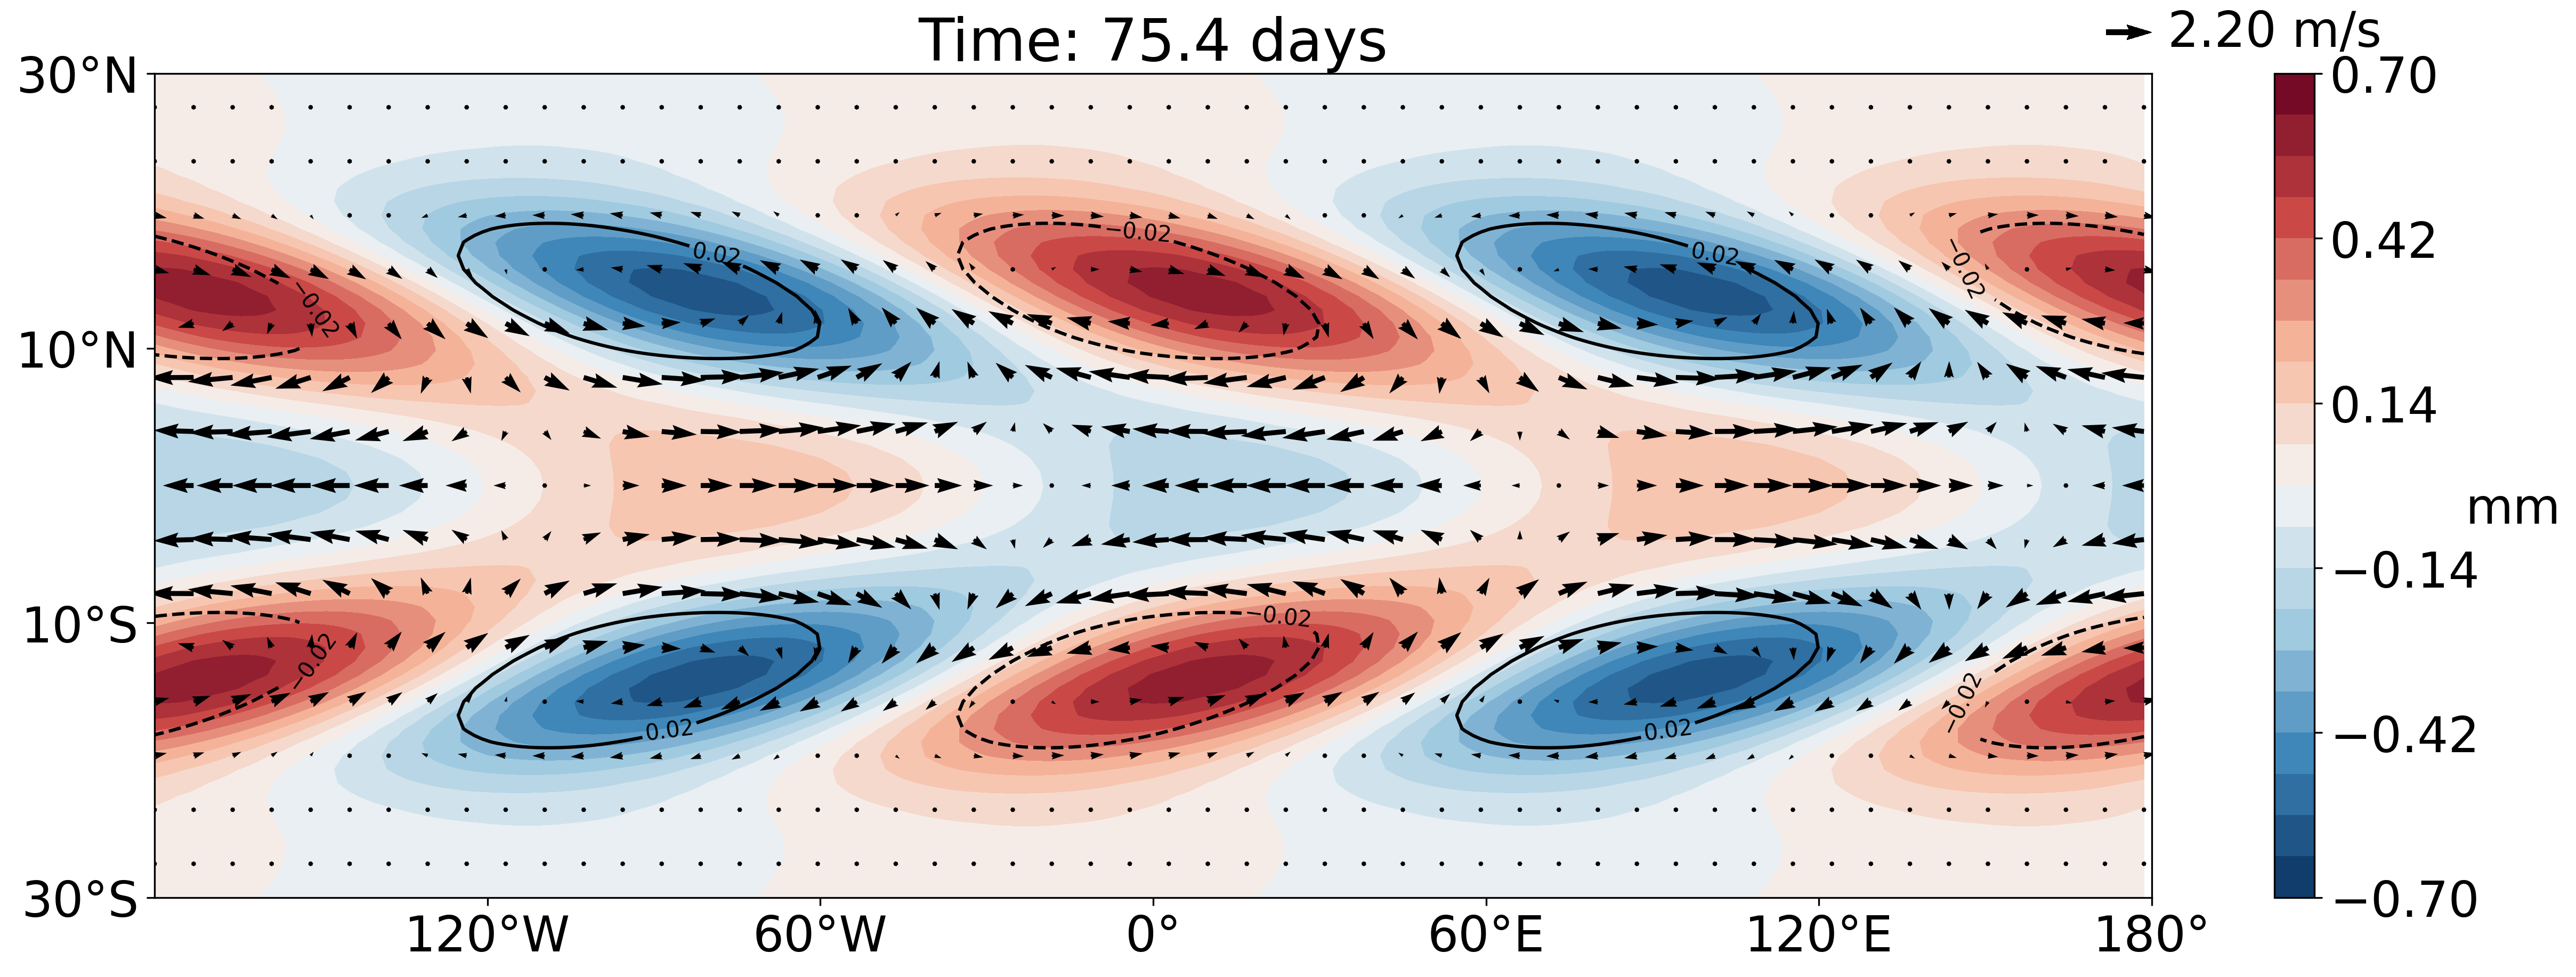

In [4]:
end_index = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 80)[0][0]
# end_index = -1

physical_parameters = (
    SPECIFIC_HEAT, 
    LATENT_HEAT,
    WATER_DENSITY,
    COLUMN_AVERAGE_MASS,
    EARTH_RADIUS,
    METERS_PER_DEGREE,
    SECONDS_PER_DAY,
)

plotting_parameters = (
    (-180, 180), (-30, 30),
    5,4,
    True, 
    'converted',
    0.6,
    grid_scaling
)

animate_horizontal_structure(
    output_zonal_gridpoints,
    output_meridional_gridpoints,
    downsampled_timepoints[:end_index],
    output_zonal_velocity[:end_index],
    output_meridional_velocity[:end_index],
    output_column_temperature[:end_index],
    -output_column_moisture[:end_index],
    specified_output_file_directory = specified_output_file_directory,
    specified_initial_condition_name = specified_initial_condition_name,
    physical_parameters = physical_parameters,
    simulation_parameters = (simulation_moisture, fringe_region),
    plotting_parameters = plotting_parameters,
    # n_frames = 50,
    # starting_frame = 0,
    # frame_interval = 5,
    n_frames = 50,
    normalized_over_time=True
)

# Budget Analysis

Calculate the contribution of each term in the MSE equation to the total budget of the wave using the following equation for some variable x
<p align="center">
    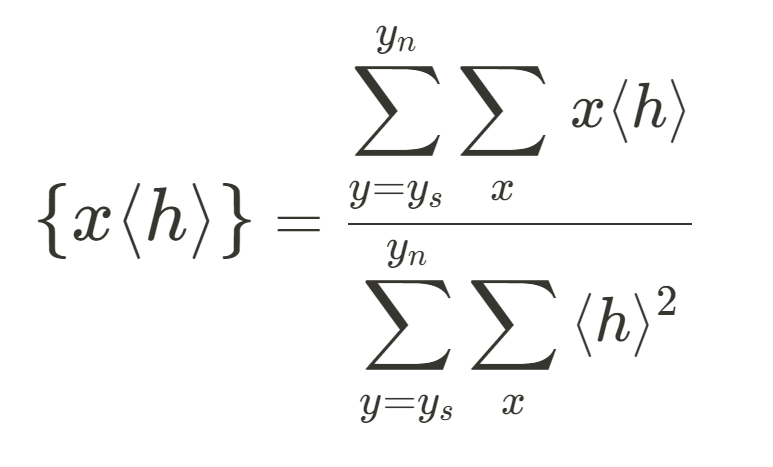
</p>

## Define budget calculation function

In [5]:
def calculate_budget(field, column_MSE):
    budget = np.einsum(
        '...ji, ...ji -> ...',
        field,
        column_MSE
    ) / np.einsum(
        '...ji, ...ji -> ...',
        column_MSE,
        column_MSE
    )
    return budget

## Growth Budget

### Calculate growth budget

In [9]:
south_bound = -30
north_bound = 30
south_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
north_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin()

# Calculate the column MSE : <h> = <T> + <q>
column_MSE = output_column_temperature + output_column_moisture

# Calculate the MSE tendency directly from the variable
MSE_tendency = np.gradient(column_MSE, downsampled_timepoints, axis=0)

# Calculate the contribution of zonal advection : σ_x {u_1 <h>}
zonal_advection_growth_contribution = ZONAL_MOISTENING_PARAMETER*calculate_budget(
    output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
    column_MSE[:, south_lat_index:north_lat_index, :]
)

# Calculate the contribution of meridional advection : -σ_y {y v_1 <h>}
meridional_advection_growth_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
    output_meridional_gridpoints[None, south_lat_index:north_lat_index, None] 
    * output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
    column_MSE[:, south_lat_index:north_lat_index, :]
)

# meridional_advection_growth_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
#     (
#         output_meridional_gridpoints 
#         * np.exp(-(output_meridional_gridpoints/3/length_scale)**2)
#     )[None, south_lat_index:north_lat_index , None]
#     * output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
#     column_MSE[:, south_lat_index:north_lat_index, :]
# )

### Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(output_zonal_velocity, axis=2)
output_dudx_fft = 1j*zonal_wavenumber[None,:]*output_ux_fft
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(output_meridional_velocity, axis=1)
output_dvdy_fft = 1j*meridional_wavenumber[:,None]*output_vy_fft
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

# Calculate the contribution of vertical advection : m M_s {ω_1 <h>}
vertical_advection_growth_contribution = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
    * GROSS_DRY_STABILITY
    * calculate_budget(
        vertical_velocity[:, south_lat_index:north_lat_index, :], 
        column_MSE[:, south_lat_index:north_lat_index, :]
    )
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
# column_convective_heating = (
#     + MOISTURE_SENSITIVITY*output_column_moisture
#     - TEMPERATURE_SENSITIVITY*output_column_temperature
# )

column_convective_heating = (
    + MOISTURE_SENSITIVITY * np.exp(-(output_meridional_gridpoints/length_scale)**2)[None, :, None] * output_column_moisture
    - TEMPERATURE_SENSITIVITY * np.exp(-(output_meridional_gridpoints/length_scale)**2)[None, :, None] * output_column_temperature
)

# Calculate column radiative heating <Q_r> = r<Q_c>
column_radiative_heating = CLOUD_RADIATIVE_PARAMETER*column_convective_heating

# Calculate the contribution of column radiative heating : {<Q_r> <h>}
column_radiative_heating_growth_contribution = calculate_budget(
    column_radiative_heating[:, south_lat_index:north_lat_index, :], 
    column_MSE[:, south_lat_index:north_lat_index, :]
)

residual_MSE_growth = (
    vertical_advection_growth_contribution
    + zonal_advection_growth_contribution
    + meridional_advection_growth_contribution
    + column_radiative_heating_growth_contribution
)

growth_budget_dataset = xr.Dataset(
    data_vars = {
        'growth' : (['time'], residual_MSE_growth),
        'omega'  : (['time'], vertical_advection_growth_contribution),
        'u'      : (['time'], zonal_advection_growth_contribution),
        'v'      : (['time'], meridional_advection_growth_contribution),
        'Qr'     : (['time'], column_radiative_heating_growth_contribution),
    },
    coords = {
        'time' : downsampled_timepoints
    },
    attrs= {
        'Latitude Bounds' : (south_bound, north_bound),
        'Initial Wavenumber' : output_wavenumber*EARTH_RADIUS
    }
)

growth_budget_dataset.to_netcdf(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_growth-budget.nc"
)
print('Growth budget saved')

Growth budget saved


### Plot at a single time

 98%|█████████████████████████████████████████████████████████████▋ | 49/50 [02:07<00:02,  2.61s/it]


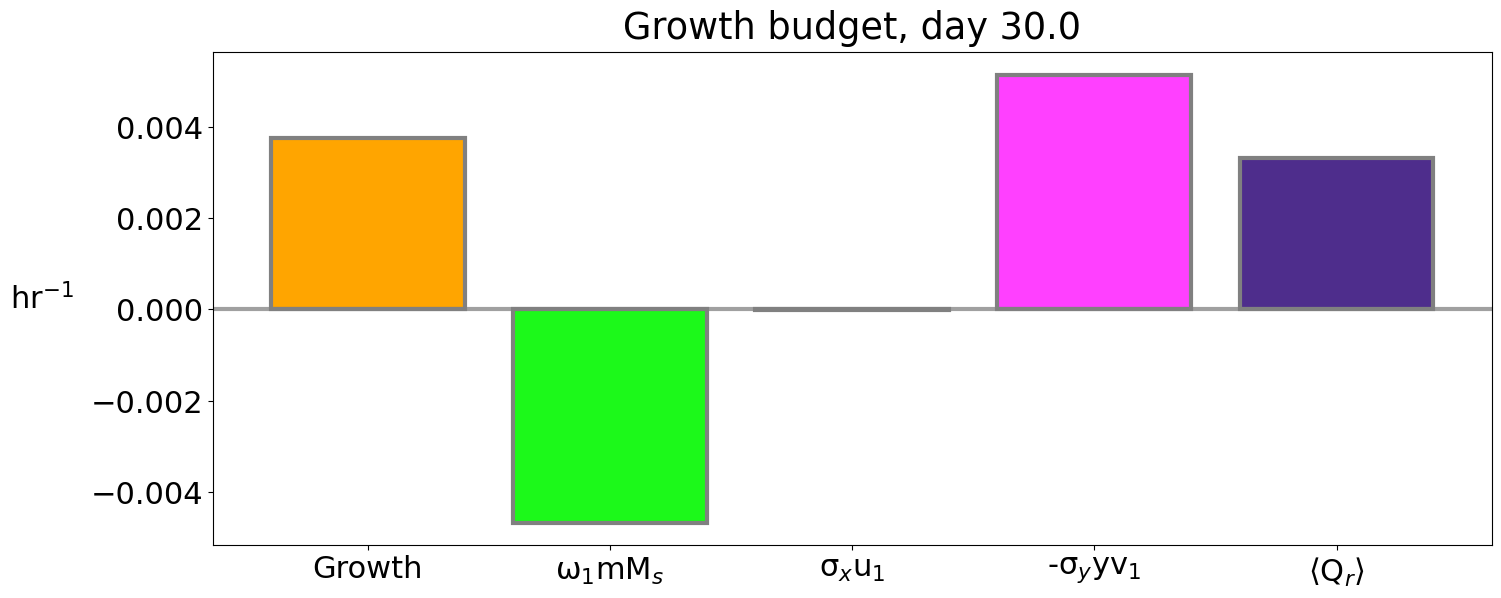

In [10]:
# Specify the time at which to calculate/plot the budget
t = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 30).argmin()

# Label the bars 
bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_values =     [
        # 3600*MSE_tendency,
        3600*residual_MSE_growth[t],   
        3600*vertical_advection_growth_contribution[t], 
        3600*zonal_advection_growth_contribution[t], 
        3600*meridional_advection_growth_contribution[t], 
        3600*column_radiative_heating_growth_contribution[t]
    ]
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

# Plot the budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))
plt.title(f"Growth budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", pad=10)
plt.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
plt.ylabel(r'hr$^{-1}$', labelpad=35, rotation=0, va='center')
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{specified_initial_condition_name}_"
#     + f"growth-budget_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days_{time.strftime('%Y%m%d-%H%M')}.png", 
#     bbox_inches='tight'
# )

### Plot as a function of time

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(16.5, 6.4))

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    3600*residual_MSE_growth,   
    color=bar_colors[0],
    label=bar_labels[0],
    lw=3
)

plt.fill_between(
    downsampled_timepoints/SECONDS_PER_DAY,
    3600*vertical_advection_growth_contribution,
    label = bar_labels[1],
    color = bar_colors[1],
    alpha=1
)

plt.stackplot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    3600*zonal_advection_growth_contribution, 
    3600*meridional_advection_growth_contribution, 
    3600*column_radiative_heating_growth_contribution,
    labels = bar_labels[2:],
    colors= bar_colors[2:],
    alpha=1
)

# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY, 
#     3600*vertical_advection_growth_contribution,
#     color=bar_colors[1],
#     label=bar_labels[1]
# )

# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY, 
#     3600*zonal_advection_growth_contribution, 

#     color=bar_colors[2],
#     label=bar_labels[2]
# )

# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY, 
#     3600*meridional_advection_growth_contribution, 

#     color=bar_colors[3],
#     label=bar_labels[3]
# )

# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY, 
#     3600*column_radiative_heating_growth_contribution,
#     color=bar_colors[4],
#     label=bar_labels[4]
# )

# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY,
#     3600*residual_MSE_growth,  
#     color='orange',
#     lw=4
# )

plt.axhline(y=0, color='#bcbcbc', ls='--', lw=3)
plt.legend(fontsize=14)
plt.xlim(10, 140)
plt.ylim(-0.02, 0.02)
plt.ylabel(r'hr$^{-1}$', labelpad=35, rotation=0, va='center')
plt.xlabel('Day')

plt.show()

### Animation

In [ ]:
starting_frame = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 70).argmin()
ending_frame = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 130).argmin()
frame_interval = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 1).argmin()

bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_values =     [
        # 3600*MSE_tendency,
        3600*residual_MSE_growth[starting_frame],   
        3600*vertical_advection_growth_contribution[starting_frame], 
        3600*zonal_advection_growth_contribution[starting_frame], 
        3600*meridional_advection_growth_contribution[starting_frame], 
        3600*column_radiative_heating_growth_contribution[starting_frame]
    ]
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.4))
ax.set_title(f"Growth budget, day {downsampled_timepoints[starting_frame]/SECONDS_PER_DAY :0.1f}", pad=15)
ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
ax.set_ylabel(r'hr$^{-1}$', labelpad=20, rotation=0, va='center')
ax.set_ylim(-0.01, 0.01)

def update(t):
    
    bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
    bar_values =     [
            # 3600*MSE_tendency,
            3600*residual_MSE_growth[t],   
            3600*vertical_advection_growth_contribution[t], 
            3600*zonal_advection_growth_contribution[t], 
            3600*meridional_advection_growth_contribution[t], 
            3600*column_radiative_heating_growth_contribution[t]
        ]
    bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

    plt.cla()
    ax.set_title(f"Growth budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", pad=15)
    ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
    ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
    ax.set_ylabel(r'hr$^{-1}$', labelpad=20, rotation=0, va='center')
    ax.set_ylim(-0.01, 0.01)

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300
)

anim.save(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_"
    + f"growth-budget_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
    dpi=300
)


### Horizontal structure

In [ ]:
plt.style.use('default')
plt.rcParams.update({'font.size':16})
fig = plt.figure(figsize=(8.5, 11))
gs_main = gs.GridSpec(1, 2, width_ratios = [40,1], figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.15)

gs_maps = gs.GridSpecFromSubplotSpec(2, 1, hspace=0.2, subplot_spec=gs_main[0])
gs_cbar = gs.GridSpecFromSubplotSpec(18, 1, subplot_spec=gs_main[1])

ax = []
# Add an axis for the initial condition
ax.append(fig.add_subplot(gs_maps[0]))
ax.append(fig.add_subplot(gs_maps[1]))

cbar_ax = fig.add_subplot(gs_cbar[1:-1, :])

t = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 30).argmin()

#### First plot
ax[0].set_title(r'(a) MSE, -σ$_y$yv$_1$, and σ$_x$u$_1$')
CF_MSE = ax[0].contourf(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    column_MSE[t]/COLUMN_AVERAGE_MASS,
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

# meridional_advection_field = -MERIDIONAL_MOISTENING_PARAMETER*output_meridional_gridpoints[None, :, None]*output_meridional_velocity
meridional_advection_field = (
    (output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/3/length_scale)**2))[None, : , None]
    * output_meridional_velocity
)

CS_v = ax[0].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    meridional_advection_field[t],
    colors=bar_colors[3],
    levels=np.delete(np.linspace(np.min(meridional_advection_field[t]), np.max(meridional_advection_field[t]), 11), [5])
)

zonal_advection_field = ZONAL_MOISTENING_PARAMETER*output_zonal_velocity
CS_u = ax[0].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    zonal_advection_field[t],
    colors=bar_colors[2],
    levels=np.delete(np.linspace(np.min(zonal_advection_field[t]), np.max(zonal_advection_field[t]), 11), [5])
)

# ax[0].set_xlim(-50, 150)
ax[0].set_ylim(-35, 35)
# ax[0].set_xticklabels(mjo.tick_labeller(np.arange(-180, 180, 30), 'lon'))
# ax[0].set_yticklabels(mjo.tick_labeller(np.arange(-50, 65, 15), 'lat'))
ax[0].set_aspect('auto')
cbar = plt.colorbar(CF_MSE, cax=cbar_ax, orientation='vertical')
cbar.set_label('K', rotation=0, va='center', labelpad=20)

#### Second Plot
ax[1].set_title(r'(b) MSE, $\langle$Q$_r$$\rangle$, and ω$_1$mM$_s$')
ax[1].contourf(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    column_MSE[t]/COLUMN_AVERAGE_MASS,
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

CS_Qr = ax[1].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    column_radiative_heating[t],
    colors=bar_colors[4],
    levels=np.delete(np.linspace(np.min(column_radiative_heating[t]), np.max(column_radiative_heating[t]), 11), [5])
)

vertical_advection_field = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
    * GROSS_DRY_STABILITY
    * vertical_velocity
)
CS_omega = ax[1].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    vertical_advection_field[t],
    colors=bar_colors[1],
    levels=np.delete(np.linspace(np.min(vertical_advection_field[t]), np.max(vertical_advection_field[t]), 11), [5])
)

# ax[1].set_xlim(-50, 150)
ax[1].set_ylim(-35, 35)
# ax[1].set_xticklabels(mjo.tick_labeller(np.arange(-180, 180, 30), 'lon'))
# ax[1].set_yticklabels(mjo.tick_labeller(np.arange(-50, 65, 15), 'lat'))
ax[1].set_aspect('auto')

plt.show()

## Propagation Budget

### Calculate propagation budget

In [ ]:
south_bound = -30
north_bound = 30
south_lat_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
north_lat_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin()

# Calculate the column MSE : <h> = <T> + <q>
column_MSE = output_column_temperature + output_column_moisture

# Calculate the MSE tendency directly from the variable
MSE_tendency = np.gradient(column_MSE, downsampled_timepoints, axis=0)

# Calculate the contribution of zonal advection : σ_x {u_1 <h>}
zonal_advection_propagation_contribution = ZONAL_MOISTENING_PARAMETER*calculate_budget(
    output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
    MSE_tendency[:, south_lat_index:north_lat_index, :]
)

# Calculate the contribution of meridional advection : -σ_y {y v_1 <h>}
# meridional_advection_propagation_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
#     meridional_gridpoints[south_lat_index:north_lat_index,None]*output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
#     MSE_tendency[:, south_lat_index:north_lat_index, :]
# )

meridional_advection_propagation_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
    (meridional_gridpoints*np.exp(-(meridional_gridpoints/3/length_scale)**2))[:,None]*output_meridional_velocity, 
    column_MSE
)

### Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(output_zonal_velocity, axis=2)
output_dudx_fft = 1j*zonal_wavenumber[None,:]*output_ux_fft
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(output_meridional_velocity, axis=1)
output_dvdy_fft = 1j*meridional_wavenumber[:,None]*output_vy_fft
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

# Calculate the contribution of vertical advection : m M_s {ω_1 <h>}
vertical_advection_propagation_contribution = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
    * GROSS_DRY_STABILITY
    * calculate_budget(
        vertical_velocity[:, south_lat_index:north_lat_index, :], 
        MSE_tendency[:, south_lat_index:north_lat_index, :]
    )
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
# column_convective_heating = (
#     + MOISTURE_SENSITIVITY*output_column_moisture
#     - TEMPERATURE_SENSITIVITY*output_column_temperature
# )

column_convective_heating = (
    + MOISTURE_SENSITIVITY * np.exp(-(output_meridional_gridpoints/length_scale)**2)[:, None] * output_column_moisture
    - TEMPERATURE_SENSITIVITY * np.exp(-(output_meridional_gridpoints/length_scale)**2)[:, None] * output_column_temperature
)

# Calculate column radiative heating <Q_r> = r<Q_c>
column_radiative_heating = CLOUD_RADIATIVE_PARAMETER*column_convective_heating

# Calculate the contribution of column radiative heating : {<Q_r> <h>}
column_radiative_heating_propagation_contribution = calculate_budget(
    column_radiative_heating[:, south_lat_index:north_lat_index, :],
    MSE_tendency[:, south_lat_index:north_lat_index, :]
)

residual_MSE_propagation = (
    vertical_advection_propagation_contribution
    + zonal_advection_propagation_contribution
    + meridional_advection_propagation_contribution
    + column_radiative_heating_propagation_contribution
)

propagation_budget_dataset = xr.Dataset(
    data_vars = {
        'propagation' : (['time'], residual_MSE_propagation),
        'omega'  : (['time'], vertical_advection_propagation_contribution),
        'u'      : (['time'], zonal_advection_propagation_contribution),
        'v'      : (['time'], meridional_advection_propagation_contribution),
        'Qr'     : (['time'], column_radiative_heating_propagation_contribution),
    },
    coords = {
        'time' : downsampled_timepoints
    },
    attrs= {
        'Latitude Bounds' : (south_bound, north_bound),
        'Initial Wavenumber' : output_wavenumber*EARTH_RADIUS
    }
)

propagation_budget_dataset.to_netcdf(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_propagation-budget.nc"
)
print('Propagation budget saved')

### Plot at a single time

In [ ]:
# Specify the time at which to calculate/plot the propagation_contribution
t = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 80).argmin()

# Label the bars 
bar_labels = [r'Propagation', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_values =     [
        # 3600*MSE_tendency,
        residual_MSE_propagation[t],   
        vertical_advection_propagation_contribution[t], 
        zonal_advection_propagation_contribution[t], 
        meridional_advection_propagation_contribution[t], 
        column_radiative_heating_propagation_contribution[t]
    ]
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

# Plot the propagation budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))
plt.title(f"Propagation budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", pad=10)
plt.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
plt.ylabel(r's$^{-1}$', labelpad=35, rotation=0, va='center')
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{specified_initial_condition_name}_"
#     + f"propagation-budget_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days_{time.strftime('%Y%m%d-%H%M')}.png", 
#     bbox_inches='tight'
# )

### Plot as a function of time

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(16.5, 6.4))

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    residual_MSE_propagation,   
    color=bar_colors[0],
    label='Propagation',
    lw=3
)

# plt.fill_between(
#     downsampled_timepoints/SECONDS_PER_DAY,
#     vertical_advection_propagation_contribution,
#     label = bar_labels[1],
#     color = bar_colors[1],
#     alpha=1
# )

# plt.stackplot(
#     downsampled_timepoints/SECONDS_PER_DAY, 
#     zonal_advection_propagation_contribution, 
#     meridional_advection_propagation_contribution, 
#     column_radiative_heating_propagation_contribution,
#     labels = bar_labels[2:],
#     colors= bar_colors[2:],
#     alpha=1
# )

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    vertical_advection_propagation_contribution,
    color=bar_colors[1],
)

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    zonal_advection_propagation_contribution, 

    color=bar_colors[2],
)

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    meridional_advection_propagation_contribution, 

    color=bar_colors[3],
)

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    column_radiative_heating_propagation_contribution,
    color=bar_colors[4],
)

plt.axhline(y=0, color='#bcbcbc', ls='--', lw=3)
plt.legend(fontsize=14)
plt.xlim(10, 180)
# plt.ylim(-0.02, 0.02)
plt.ylabel(r's$^{-1}$', labelpad=35, rotation=0, va='center')
plt.xlabel('Day')

plt.show()

### Animation

In [ ]:
starting_frame = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 10).argmin()
ending_frame = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 130).argmin()
frame_interval = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 1).argmin()


# Label the bars 
bar_labels = [r'Propagation', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_values =     [
        # 3600*MSE_tendency,
        residual_MSE_propagation[starting_frame],   
        vertical_advection_propagation_contribution[starting_frame], 
        zonal_advection_propagation_contribution[starting_frame], 
        meridional_advection_propagation_contribution[starting_frame], 
        column_radiative_heating_propagation_contribution[starting_frame]
    ]
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']


[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.4))
ax.set_title(f"Propagation budget, day {downsampled_timepoints[starting_frame]/SECONDS_PER_DAY :0.1f}", pad=15)
ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
ax.set_ylabel(r's$^{-1}$', labelpad=20, rotation=0, va='center')
ax.set_ylim(-1, 1)

def update(t):
    
    bar_labels = [r'Propagation', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
    bar_values =     [
            # 3600*MSE_tendency,
            residual_MSE_propagation[t],   
            vertical_advection_propagation_contribution[t], 
            zonal_advection_propagation_contribution[t], 
            meridional_advection_propagation_contribution[t], 
            column_radiative_heating_propagation_contribution[t]
        ]
    bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

    plt.cla()
    ax.set_title(f"Propagation budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", pad=15)
    ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
    ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
    ax.set_ylabel(r's$^{-1}$', labelpad=20, rotation=0, va='center')
    ax.set_ylim(-1, 1)

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300
)

anim.save(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_"
    + f"propagation-budget_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
    dpi=300
    )


### Horizontal structure

In [ ]:
fig = plt.figure(figsize=(11, 8.5))
gs_main = gs.GridSpec(2, 2, width_ratios = [40,1], figure=fig)
gs_main.update(left=0.1, right=0.9, top=0.95, bottom=0.05, wspace=0.2)

ax = []
# Add an axis for the initial condition
ax.append(fig.add_subplot(gs_main[0, 0]))
ax.append(fig.add_subplot(gs_main[1 ,0]))

cbar_ax = fig.add_subplot(gs_main[:, 1])

#### First plot
ax[0].set_title(r'$\frac{dMSE}{dt}$, -σ$_y$yv$_1$, and σ$_x$u$_1$')
CF_MSE = ax[0].contourf(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    MSE_tendency[t],
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)


meridional_advection_field = -MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*output_meridional_velocity
CS_v = ax[0].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    meridional_advection_field[t],
    colors=bar_colors[3],
    levels=np.delete(np.linspace(np.min(meridional_advection_field[t]), np.max(meridional_advection_field[t]), 11), [5])
)

zonal_advection_field = ZONAL_MOISTENING_PARAMETER*output_zonal_velocity
CS_u = ax[0].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    zonal_advection_field[t],
    colors=bar_colors[2],
    levels=np.delete(np.linspace(np.min(zonal_advection_field[t]), np.max(zonal_advection_field[t]), 11), [5])
)

ax[0].set_ylim(-35, 35)
# ax[0].set_xlim(-50, 150)
ax[0].set_aspect('equal')
plt.colorbar(CF_MSE, cax=cbar_ax, orientation='vertical')

#### Second Plot
ax[1].set_title(r'$\frac{dMSE}{dt}$, $\langle$Q$_r$$\rangle$, and ω$_1$mM$_s$')
ax[1].contourf(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    MSE_tendency[t],
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

CS_Qr = ax[1].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    column_radiative_heating[t],
    colors=bar_colors[4],
    levels=np.delete(np.linspace(np.min(column_radiative_heating[t]), np.max(column_radiative_heating[t]), 11), [5])
)

vertical_advection_field = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
    * GROSS_DRY_STABILITY
    * vertical_velocity
)
CS_omega = ax[1].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    vertical_advection_field[t],
    colors=bar_colors[1],
    levels=np.delete(np.linspace(np.min(vertical_advection_field[t]), np.max(vertical_advection_field[t]), 11), [5])
)

ax[1].set_ylim(-35, 35)
# ax[1].set_xlim(-50, 150)
ax[1].set_aspect('equal')
plt.show()

# Load data metrics

In [ ]:
experiment_to_load = specified_output_file_directory
initial_conditions_to_load = [f"k=1.0_m=1_Kelvin-wave", f"k=2.0_m=1_Kelvin-wave", f"k=3.0_m=1_Kelvin-wave", f"k=4.0_m=1_Kelvin-wave"]

phase_speeds = {}
growth_budgets = {}
propagation_budgets = {}
for ic in initial_conditions_to_load:
    phase_speeds[ic] = xr.load_dataset(f"{specified_output_file_directory}/{ic}_instantaneous-phase-speed.nc")['phase speed']
    growth_budgets[ic] = xr.load_dataset(f"{specified_output_file_directory}/{ic}_growth-budget.nc")
    propagation_budgets[ic] = xr.load_dataset(f"{specified_output_file_directory}/{ic}_propagation-budget.nc")

print("Data loaded")

In [ ]:
for g in growth_budgets:
    print(growth_budgets[g])

In [ ]:
# Label the bars 
bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

t = np.abs(phase_speeds[exp]['time']/SECONDS_PER_DAY - 30).argmin()

width = 0.15
multiplier = 0
x = np.arange(len(bar_labels))

plt.style.use('default')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))
for exp in growth_budgets:
    offset = width * multiplier
    bar_values = [
            3600*growth_budgets[exp]['growth'][t],
            3600*growth_budgets[exp]['omega'][t],
            3600*growth_budgets[exp]['u'][t],
            3600*growth_budgets[exp]['v'][t],
            3600*growth_budgets[exp]['Qr'][t]
        ]
    rects = ax.bar(
        x + offset, 
        bar_values, 
        label = exp, 
        color = bar_colors, 
        width = width,
        edgecolor='gray', 
        linewidth=3,
        align='center'
    )    
    # ax.bar_label(rects, padding=0.3)
    multiplier += 1

    for l in range(len(bar_labels)):
        ax.text(l, 0.0105, s=bar_labels[l])# bbox=dict(facecolor='#eeeeee', edgecolor='#bcbcbc', boxstyle='round, pad=0.25'))

ax.axhline(y = 0, color='gray', lw=2)

ax.set_title(f"Growth Budget, Day {growth_budgets[exp]['time'][t]/SECONDS_PER_DAY:0.1f}", pad=50) 
ax.set_ylim(-0.01, 0.01)
ax.set_xticks(
    np.concatenate((x, x+offset/3, x+2*offset/3, x+offset)),
    sorted(np.arange(len(bar_labels)*len(initial_conditions_to_load))%len(initial_conditions_to_load)+1)
)
ax.set_ylabel(r'hr$^{-1}$', rotation=0, labelpad=20)
ax.set_xlabel('Zonal Wavenumber', labelpad=10)
# ax.legend()
plt.show()

In [ ]:
# Label the bars 
bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

t = np.abs(phase_speeds[exp]['time']/SECONDS_PER_DAY - 30).argmin()

width = 0.15
multiplier = 0
x = np.arange(len(bar_labels))

y_max = 2.25

plt.style.use('default')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))
for exp in propagation_budgets:
    offset = width * multiplier
    bar_values = [
            propagation_budgets[exp]['propagation'][t],
            propagation_budgets[exp]['omega'][t],
            propagation_budgets[exp]['u'][t],
            propagation_budgets[exp]['v'][t],
            propagation_budgets[exp]['Qr'][t]
        ]
    rects = ax.bar(
        x + offset, 
        bar_values, 
        label = exp, 
        color = bar_colors, 
        width = width,
        edgecolor='gray', 
        linewidth=3,
        align='center'
    )    
    # ax.bar_label(rects, padding=0.3)
    multiplier += 1

    for l in range(len(bar_labels)):
        ax.text(l, y_max + 0.105, s=bar_labels[l])# bbox=dict(facecolor='#eeeeee', edgecolor='#bcbcbc', boxstyle='round, pad=0.25'))

ax.axhline(y = 0, color='gray', lw=2)

ax.set_title(f"Propagation Budget, Day {propagation_budgets[exp]['time'][t]/SECONDS_PER_DAY:0.1f}", pad=50) 
ax.set_ylim(-1.0, y_max)
# ax.set_xticks(np.append(x, x+offset), np.arange(len(bar_labels)*len(initial_conditions_to_load))%len(initial_conditions_to_load)+1)
ax.set_xticks(
    np.concatenate((x, x+offset/3, x+2*offset/3, x+offset)),
    sorted(np.arange(len(bar_labels)*len(initial_conditions_to_load))%len(initial_conditions_to_load)+1)
)
ax.set_ylabel(r's$^{-1}$', rotation=0, labelpad=20)
ax.set_xlabel('Zonal Wavenumber', labelpad=10)
# ax.legend()
plt.show()